In [1]:
import numpy as np
import xarray as xr
import salishsea_tools.river_202108 as rivers
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import signal

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

In [5]:
fw_rivers_fraser = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_Fraser_all_20120101_20140101.nc')
fw_rivers_subset = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_subset_all_20120101_20140101.nc')
fw_rivers_other = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_other_all_20120101_20140101.nc')
fw_rivers_nooksack = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_one_nooksack_all_20120101_20160101.nc')

# time = fw_rivers_fraser['time'].to_numpy()
fraser_file = '1d_hindcast_volume_fraser_river_s2012_1462_dep_0_40.csv'
fraser_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + fraser_file)['0'].to_numpy()

nooksack_file = '1d_hindcast_volume_nooksack_river_s2012_1462_dep_0_40.csv'
nooksack_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + nooksack_file)['0'].to_numpy()

skagit_file = '1d_hindcast_volume_skagit_river_s2012_1462_dep_0_40.csv'
skagit_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + skagit_file)['0'].to_numpy()

snohomish_file = '1d_hindcast_volume_snohomish_river_s2012_1462_dep_0_40.csv'
snohomish_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + snohomish_file)['0'].to_numpy()

nisqually_file = '1d_hindcast_volume_nisqually_river_s2012_1462_dep_0_40.csv'
nisqually_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + nisqually_file)['0'].to_numpy()

elwha_file = '1d_hindcast_volume_elwha_river_s2012_1462_dep_0_40.csv'
elwha_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + elwha_file)['0'].to_numpy()

cowichan_file = '1d_hindcast_volume_cowichan_river_s2012_1462_dep_0_40.csv'
cowichan_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + cowichan_file)['0'].to_numpy()

nanaimo_file = '1d_hindcast_volume_nanaimo_river_s2012_1462_dep_0_40.csv'
nanaimo_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + nanaimo_file)['0'].to_numpy()

puntledge_file = '1d_hindcast_volume_puntledge_river_s2012_1462_dep_0_40.csv'
puntledge_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + puntledge_file)['0'].to_numpy()

salmon_file = '1d_hindcast_volume_salmon_river_s2012_1462_dep_0_40.csv'
salmon_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + salmon_file)['0'].to_numpy()

homathko_file = '1d_hindcast_volume_homathko_river_s2012_1462_dep_0_40.csv'
homathko_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + homathko_file)['0'].to_numpy()

squamish_file = '1d_hindcast_volume_squamish_river_s2012_1462_dep_0_40.csv'
squamish_arr = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/' + squamish_file)['0'].to_numpy()

In [7]:
Fraser_mod = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/river_dailies_to_ts_Fraser_20120101_20150101.csv')
Fraser_mod['date'] = pd.to_datetime(Fraser_mod['date'], format='%m-%d-%Y')

rho = 1026
runoff_to_m3 = 86400 * (500*440)/rho

color1 = '#4f8cf0'
color2 = '#162845'
color3 = '#345d9e'

In [8]:
# Sampling frequency (once per day)
Fs = 1  # Samples per day
# Nyquist frequency
Fn = Fs / 2
# Cutoff frequency (less than once per year)
Fc = 0.5 / 365  # Frequency in Hz
# Design a low-pass filter
order = 4  # Filter order
b, a = signal.butter(order, Fc / Fn, 'low')

## Exponential Fits

In [9]:
def days_vols(idxs, ds, arr):
    days = [ds['time'][idxs[0]], ds['time'][idxs[1]], ds['time'][idxs[2]]]
    vols = [arr[idxs[0]], arr[idxs[1]], arr[idxs[2]]]
    return days, vols

In [10]:
def resample_mean(arr, chunk_size):
    if len(arr) % chunk_size != 0:
        raise ValueError("Array length must be divisible by chunk size")

    num_chunks = len(arr) // chunk_size
    return np.mean(arr[:num_chunks * chunk_size].reshape(num_chunks, chunk_size), axis=1)

In [11]:
def model(t, A, T):
    return A * (1 - np.exp(-t / T))

In [12]:
def model_inv(y, A, T):
    return -T * np.log(1 - (y/A))

In [13]:
def fit_and_plot(initial_guess, t_data, Y_data, region):
    popt, pcov = curve_fit(model, t_data, Y_data, p0=initial_guess)
    A_opt, T_opt = popt

    T_80pct = model_inv(A_opt*0.8, A_opt, T_opt)
    T_90pct = model_inv(A_opt*0.9, A_opt, T_opt)
    T_95pct = model_inv(A_opt*0.95, A_opt, T_opt)
    T_99pct = model_inv(A_opt*0.99, A_opt, T_opt)

    print("Optimized parameters:")
    print("A = {:.0f} m^3".format(A_opt))
    print("T = {:.0f} days, {:.2f} years".format(T_opt, T_opt/365))
    print('T_80pct = {:.2f} years'.format(T_80pct/365))
    print('T_90pct = {:.2f} years'.format(T_90pct/365))
    print('T_95pct = {:.2f} years'.format(T_95pct/365))
    print('T_99pct = {:.2f} years'.format(T_99pct/365))

    # Generate the fitted curve
    t_fit = np.linspace(0, max(t_data)*2, 100)
    Y_fit = model(t_fit, A_opt, T_opt)

    # Plot the original data and the fitted curve
    plt.plot(t_data, Y_data, 'bo', label='Data')
    plt.plot(t_fit, Y_fit, 'r-', label='Fitted curve')
    plt.vlines([T_opt, T_80pct, T_90pct, T_95pct, T_99pct], [0, 0, 0, 0, 0], [A_opt, A_opt, A_opt, A_opt, A_opt], 'k', linestyle='--', alpha=0.5)
    plt.xlabel('t: Days since start of run')
    plt.ylabel(r'Y: $m^3$ freshwater')
    plt.legend()
    plt.title('{} Exponential Fit'.format(region))
    plt.show()

    return A_opt, T_opt, T_95pct

In [14]:
idxs = [0, 366, 731]

Optimized parameters:
A = 81500844978 m^3
T = 359 days, 0.98 years
T_80pct = 1.59 years
T_90pct = 2.27 years
T_95pct = 2.95 years
T_99pct = 4.54 years


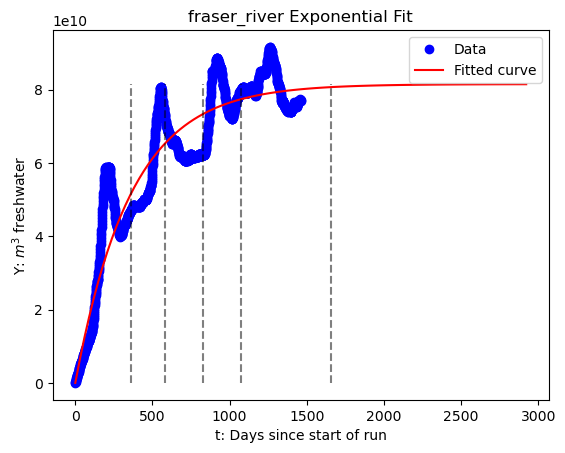

Optimized parameters:
A = 82496286018 m^3
T = 391 days, 1.07 years
T_80pct = 1.72 years
T_90pct = 2.47 years
T_95pct = 3.21 years
T_99pct = 4.93 years


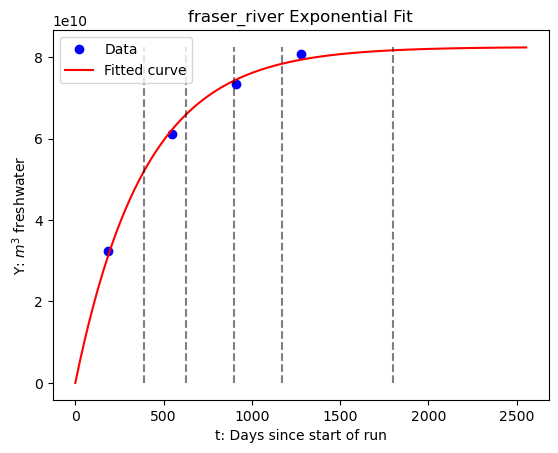

Optimized parameters:
A = 83879627822 m^3
T = 396 days, 1.08 years
T_80pct = 1.75 years
T_90pct = 2.50 years
T_95pct = 3.25 years
T_99pct = 4.99 years


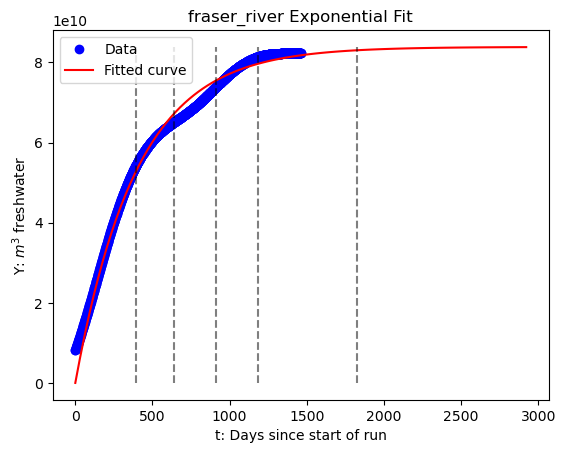

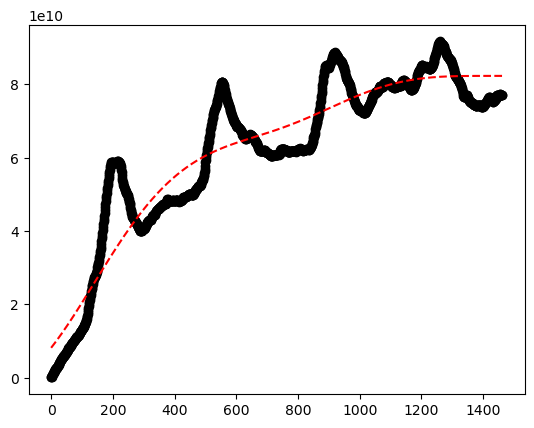

In [15]:
variable = 'fraser_river'
days, vols = days_vols(idxs, fw_rivers_fraser, fraser_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_fraser_data, T_opt_fraser_data, T_95pct_fraser_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(fraser_arr)), Y_data=fraser_arr, region=variable)

chunk_size = 365
data_arr = fraser_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_fraser_mean, T_opt_fraser_mean, T_95pct_fraser_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, fraser_arr)
A_opt_fraser, T_opt_fraser, T_95pct_fraser = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(fraser_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(fraser_arr)), fraser_arr, 'ko')
plt.plot(np.arange(0, len(fraser_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 322329121 m^3
T = 193 days, 0.53 years
T_80pct = 0.85 years
T_90pct = 1.21 years
T_95pct = 1.58 years
T_99pct = 2.43 years


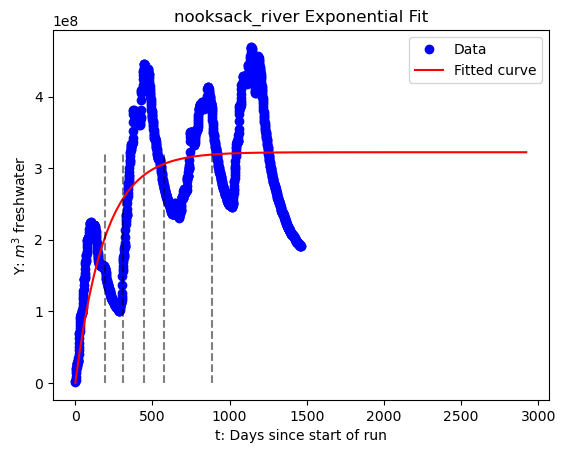

Optimized parameters:
A = 335498675 m^3
T = 251 days, 0.69 years
T_80pct = 1.11 years
T_90pct = 1.58 years
T_95pct = 2.06 years
T_99pct = 3.17 years


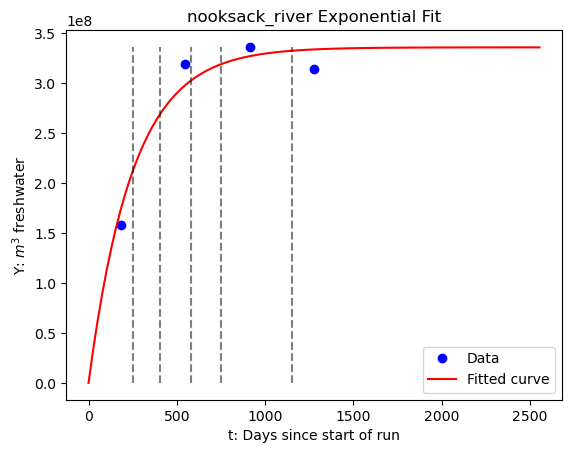

Optimized parameters:
A = 353747709 m^3
T = 257 days, 0.71 years
T_80pct = 1.14 years
T_90pct = 1.62 years
T_95pct = 2.11 years
T_99pct = 3.25 years


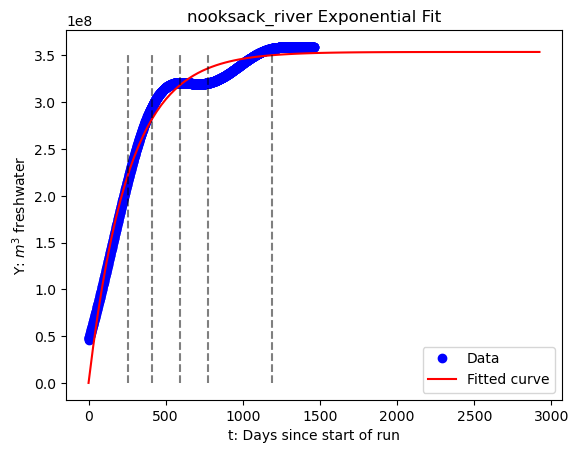

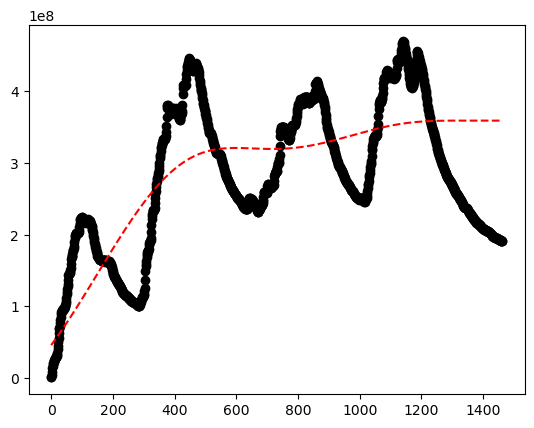

In [16]:
variable = 'nooksack_river'
days, vols = days_vols(idxs, fw_rivers_subset, nooksack_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_nooksack_data, T_opt_nooksack_data, T_95pct_nooksack_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nooksack_arr)), Y_data=nooksack_arr, region=variable)

chunk_size = 365
data_arr = nooksack_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_nooksack_mean, T_opt_nooksack_mean, T_95pct_nooksack_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, nooksack_arr)
A_opt_nooksack, T_opt_nooksack, T_95pct_nooksack = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nooksack_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(nooksack_arr)), nooksack_arr, 'ko')
plt.plot(np.arange(0, len(nooksack_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 3581627022 m^3
T = 218 days, 0.60 years
T_80pct = 0.96 years
T_90pct = 1.37 years
T_95pct = 1.79 years
T_99pct = 2.75 years


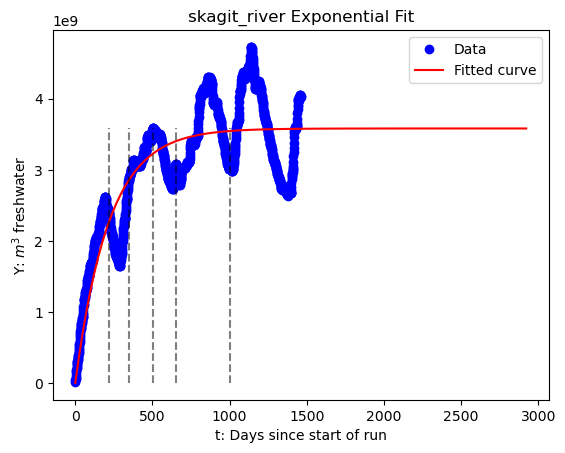

Optimized parameters:
A = 3671199311 m^3
T = 263 days, 0.72 years
T_80pct = 1.16 years
T_90pct = 1.66 years
T_95pct = 2.16 years
T_99pct = 3.32 years


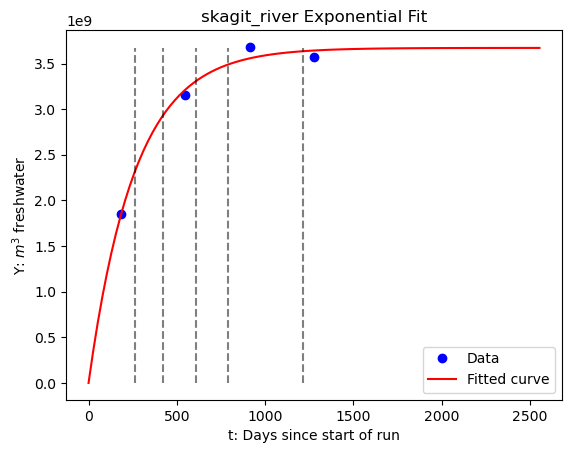

Optimized parameters:
A = 3832231543 m^3
T = 280 days, 0.77 years
T_80pct = 1.23 years
T_90pct = 1.77 years
T_95pct = 2.30 years
T_99pct = 3.53 years


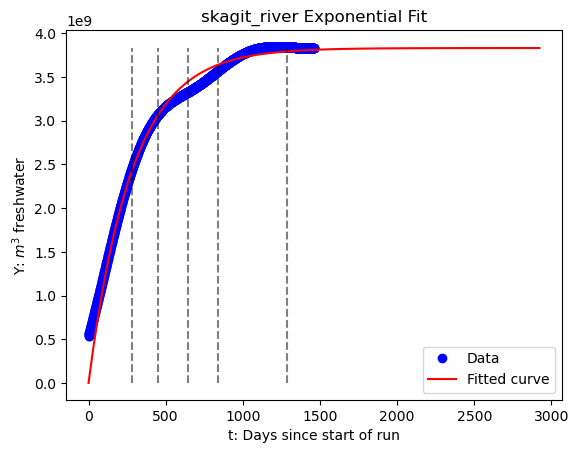

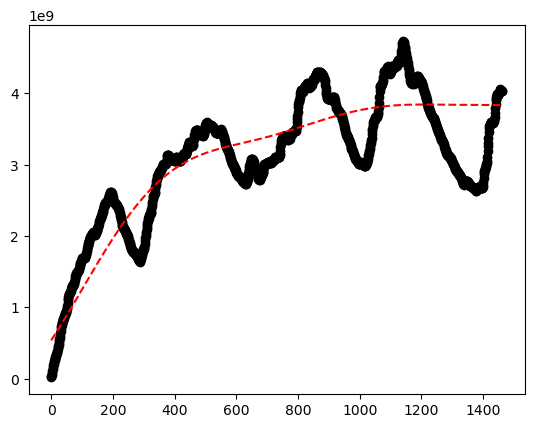

In [17]:
variable = 'skagit_river'
days, vols = days_vols(idxs, fw_rivers_subset, skagit_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_skagit_data, T_opt_skagit_data, T_95pct_skagit_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(skagit_arr)), Y_data=skagit_arr, region=variable)

chunk_size = 365
data_arr = skagit_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_skagit_mean, T_opt_skagit_mean, T_95pct_skagit_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, skagit_arr)
A_opt_skagit, T_opt_skagit, T_95pct_skagit = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(skagit_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(skagit_arr)), skagit_arr, 'ko')
plt.plot(np.arange(0, len(skagit_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 5261514271 m^3
T = 216 days, 0.59 years
T_80pct = 0.95 years
T_90pct = 1.36 years
T_95pct = 1.77 years
T_99pct = 2.73 years


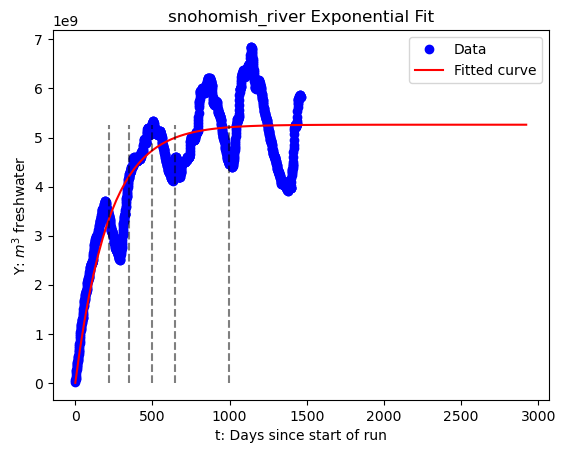

Optimized parameters:
A = 5387273905 m^3
T = 261 days, 0.72 years
T_80pct = 1.15 years
T_90pct = 1.65 years
T_95pct = 2.14 years
T_99pct = 3.29 years


/tmp/ipykernel_4179074/3982814335.py:2: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(-t / T))


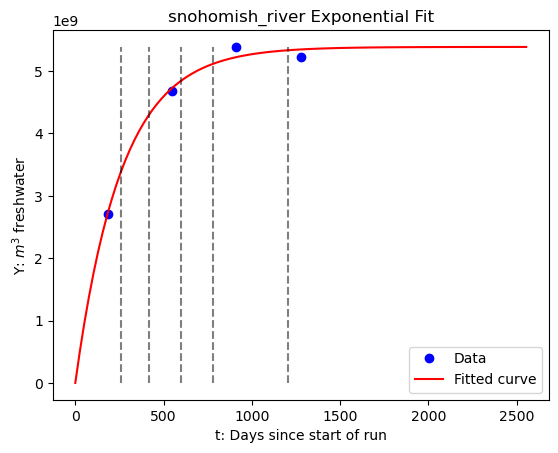

Optimized parameters:
A = 5599838576 m^3
T = 273 days, 0.75 years
T_80pct = 1.20 years
T_90pct = 1.72 years
T_95pct = 2.24 years
T_99pct = 3.45 years


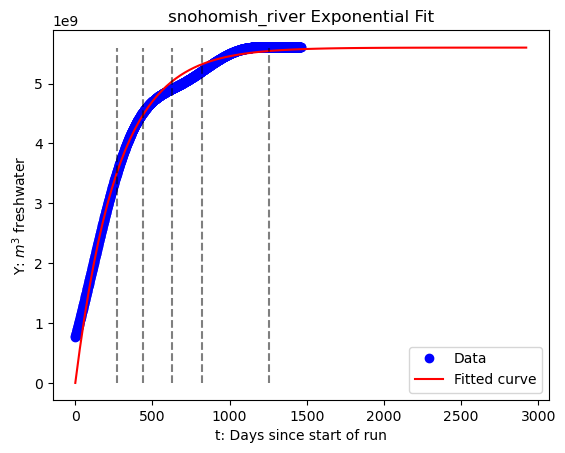

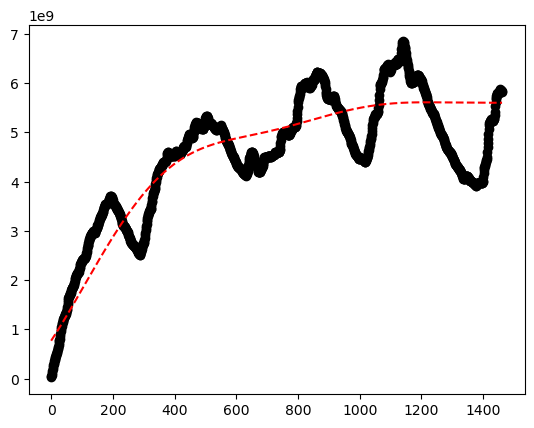

In [18]:
variable = 'snohomish_river'
days, vols = days_vols(idxs, fw_rivers_subset, snohomish_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_snohomish_data, T_opt_snohomish_data, T_95pct_snohomish_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(snohomish_arr)), Y_data=snohomish_arr, region=variable)

chunk_size = 365
data_arr = snohomish_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_snohomish_mean, T_opt_snohomish_mean, T_95pct_snohomish_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, snohomish_arr)
A_opt_snohomish, T_opt_snohomish, T_95pct_snohomish = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(snohomish_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(snohomish_arr)), snohomish_arr, 'ko')
plt.plot(np.arange(0, len(snohomish_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 2025276739 m^3
T = 200 days, 0.55 years
T_80pct = 0.88 years
T_90pct = 1.26 years
T_95pct = 1.64 years
T_99pct = 2.52 years


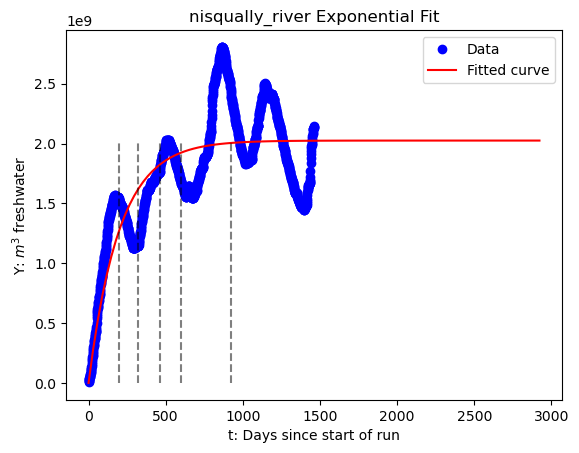

Optimized parameters:
A = 2082687885 m^3
T = 252 days, 0.69 years
T_80pct = 1.11 years
T_90pct = 1.59 years
T_95pct = 2.07 years
T_99pct = 3.18 years


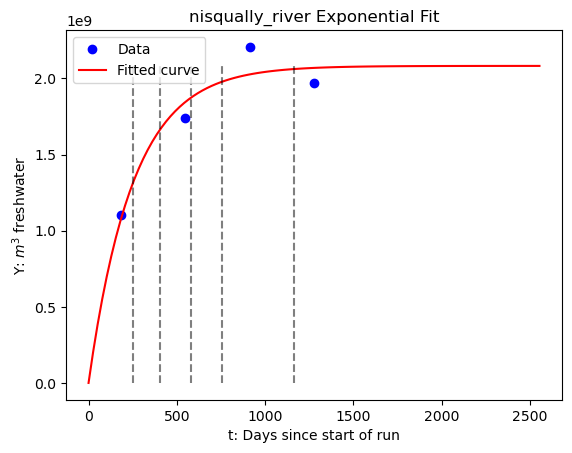

Optimized parameters:
A = 2208729150 m^3
T = 281 days, 0.77 years
T_80pct = 1.24 years
T_90pct = 1.77 years
T_95pct = 2.30 years
T_99pct = 3.54 years


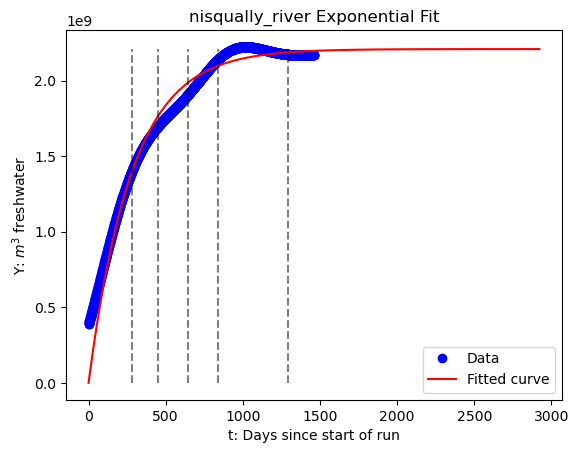

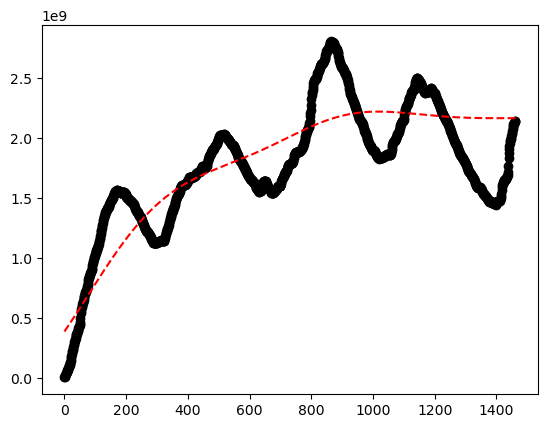

In [19]:
variable = 'nisqually_river'
days, vols = days_vols(idxs, fw_rivers_subset, nisqually_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_nisqually_data, T_opt_nisqually_data, T_95pct_nisqually_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nisqually_arr)), Y_data=nisqually_arr, region=variable)

chunk_size = 365
data_arr = nisqually_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_nisqually_mean, T_opt_nisqually_mean, T_95pct_nisqually_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, nisqually_arr)
A_opt_nisqually, T_opt_nisqually, T_95pct_nisqually = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nisqually_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(nisqually_arr)), nisqually_arr, 'ko')
plt.plot(np.arange(0, len(nisqually_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 454297564 m^3
T = 158 days, 0.43 years
T_80pct = 0.70 years
T_90pct = 1.00 years
T_95pct = 1.29 years
T_99pct = 1.99 years


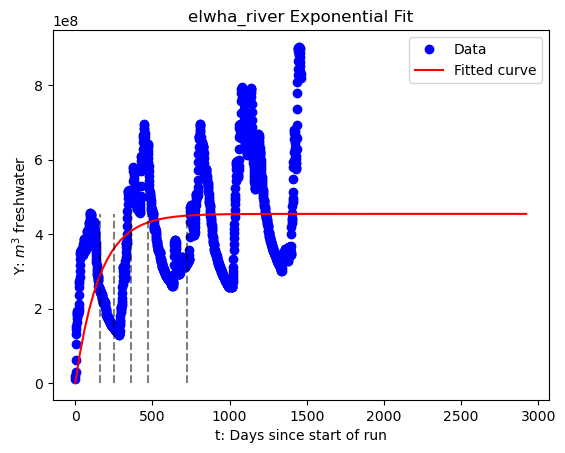

Optimized parameters:
A = 477082001 m^3
T = 222 days, 0.61 years
T_80pct = 0.98 years
T_90pct = 1.40 years
T_95pct = 1.82 years
T_99pct = 2.80 years


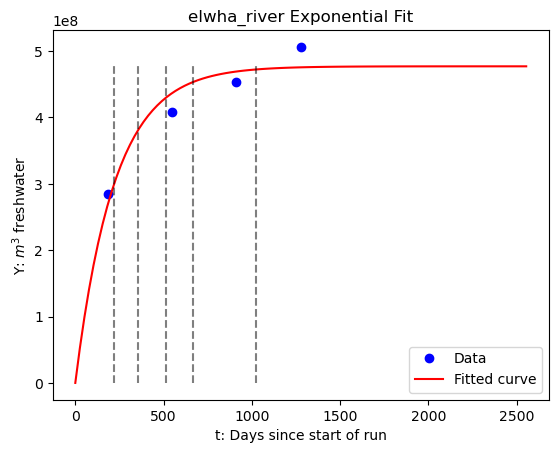

Optimized parameters:
A = 475744092 m^3
T = 221 days, 0.60 years
T_80pct = 0.97 years
T_90pct = 1.39 years
T_95pct = 1.81 years
T_99pct = 2.78 years


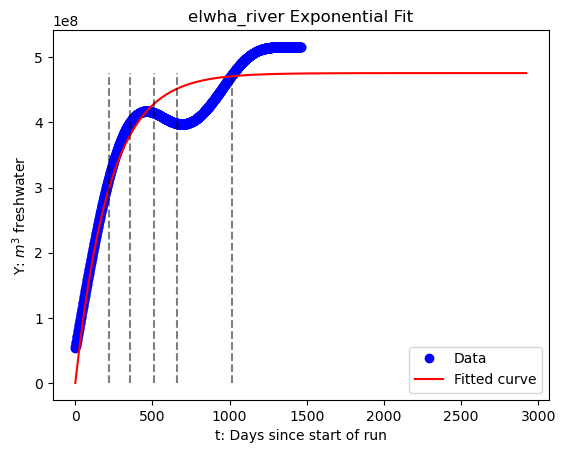

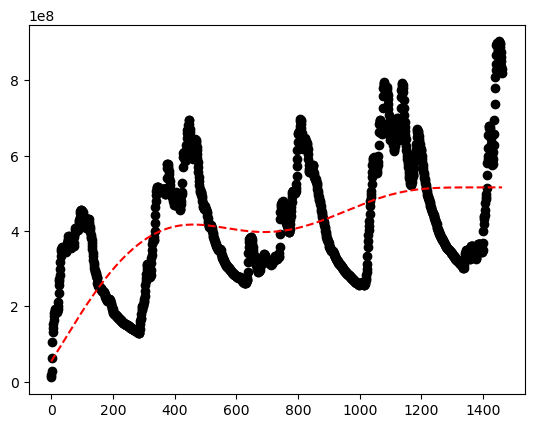

In [20]:
variable = 'elwha_river'
days, vols = days_vols(idxs, fw_rivers_subset, elwha_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_elwha_data, T_opt_elwha_data, T_95pct_elwha_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(elwha_arr)), Y_data=elwha_arr, region=variable)

chunk_size = 365
data_arr = elwha_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_elwha_mean, T_opt_elwha_mean, T_95pct_elwha_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, elwha_arr)
A_opt_elwha, T_opt_elwha, T_95pct_elwha = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(elwha_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(elwha_arr)), elwha_arr, 'ko')
plt.plot(np.arange(0, len(elwha_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 497006339 m^3
T = 176 days, 0.48 years
T_80pct = 0.77 years
T_90pct = 1.11 years
T_95pct = 1.44 years
T_99pct = 2.21 years


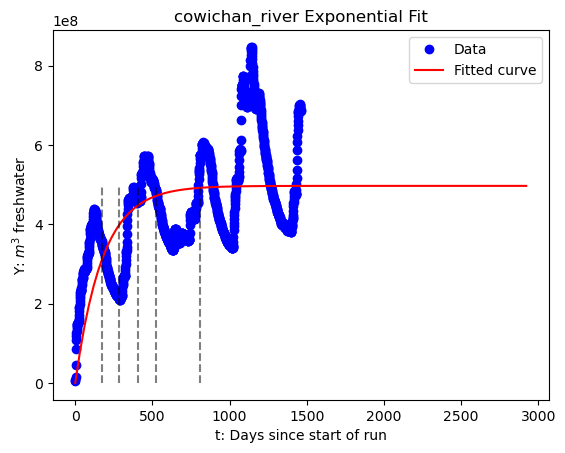

Optimized parameters:
A = 519185354 m^3
T = 239 days, 0.65 years
T_80pct = 1.05 years
T_90pct = 1.51 years
T_95pct = 1.96 years
T_99pct = 3.01 years


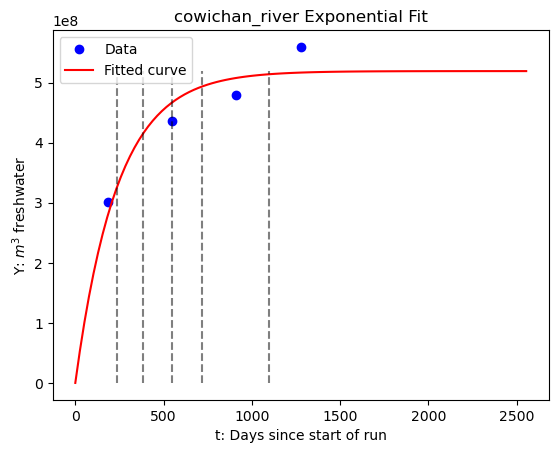

Optimized parameters:
A = 543507439 m^3
T = 276 days, 0.76 years
T_80pct = 1.22 years
T_90pct = 1.74 years
T_95pct = 2.27 years
T_99pct = 3.48 years


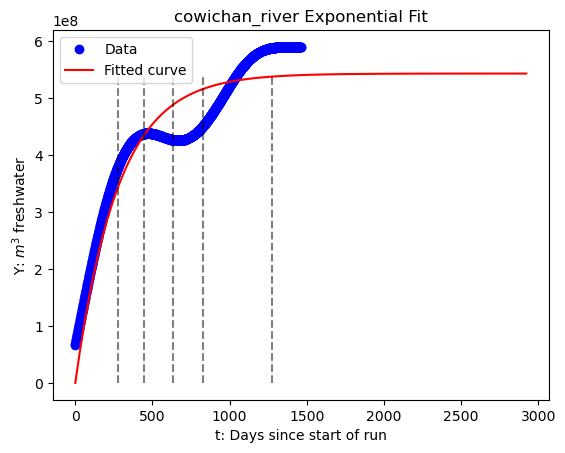

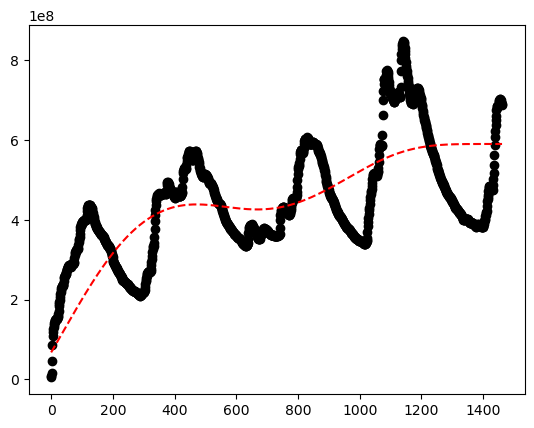

In [21]:
variable = 'cowichan_river'
days, vols = days_vols(idxs, fw_rivers_subset, cowichan_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_cowichan_data, T_opt_cowichan_data, T_95pct_cowichan_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(cowichan_arr)), Y_data=cowichan_arr, region=variable)

chunk_size = 365
data_arr = cowichan_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_cowichan_mean, T_opt_cowichan_mean, T_95pct_cowichan_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, cowichan_arr)
A_opt_cowichan, T_opt_cowichan, T_95pct_cowichan = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(cowichan_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(cowichan_arr)), cowichan_arr, 'ko')
plt.plot(np.arange(0, len(cowichan_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 648719082 m^3
T = 234 days, 0.64 years
T_80pct = 1.03 years
T_90pct = 1.48 years
T_95pct = 1.92 years
T_99pct = 2.95 years


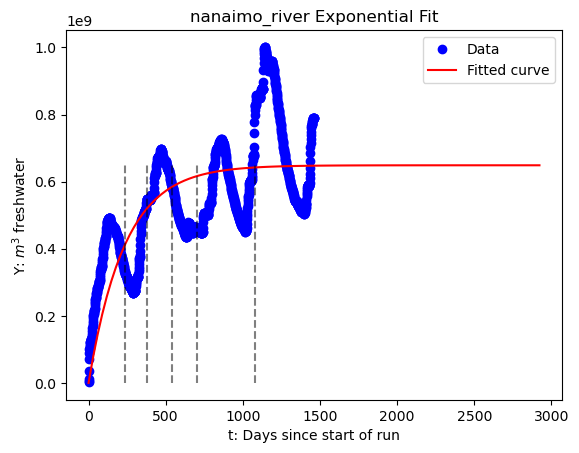

Optimized parameters:
A = 676931980 m^3
T = 293 days, 0.80 years
T_80pct = 1.29 years
T_90pct = 1.85 years
T_95pct = 2.41 years
T_99pct = 3.70 years


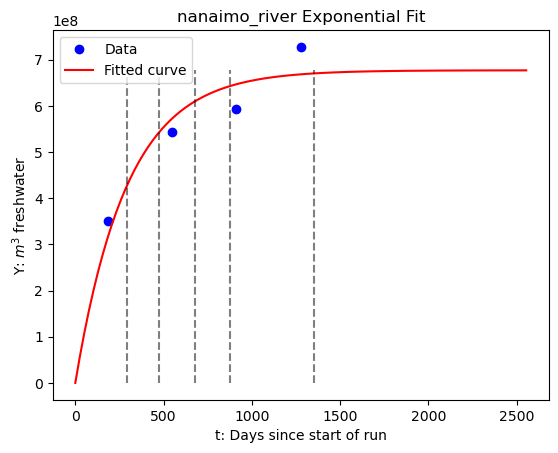

Optimized parameters:
A = 707617541 m^3
T = 329 days, 0.90 years
T_80pct = 1.45 years
T_90pct = 2.07 years
T_95pct = 2.70 years
T_99pct = 4.15 years


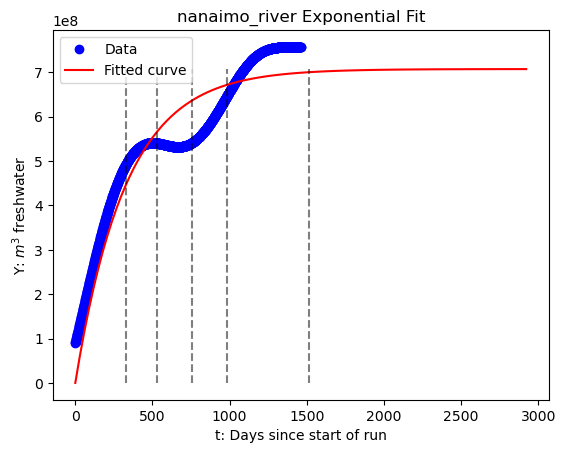

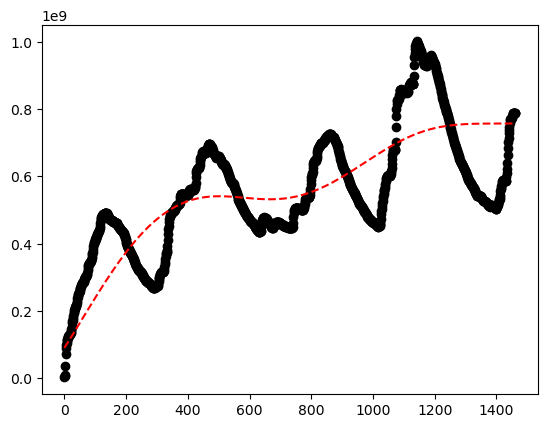

In [22]:
variable = 'nanaimo_river'
days, vols = days_vols(idxs, fw_rivers_subset, nanaimo_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_nanaimo_data, T_opt_nanaimo_data, T_95pct_nanaimo_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nanaimo_arr)), Y_data=nanaimo_arr, region=variable)

chunk_size = 365
data_arr = nanaimo_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_nanaimo_mean, T_opt_nanaimo_mean, T_95pct_nanaimo_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, nanaimo_arr)
A_opt_nanaimo, T_opt_nanaimo, T_95pct_nanaimo = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(nanaimo_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(nanaimo_arr)), nanaimo_arr, 'ko')
plt.plot(np.arange(0, len(nanaimo_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 1166536299 m^3
T = 239 days, 0.65 years
T_80pct = 1.05 years
T_90pct = 1.51 years
T_95pct = 1.96 years
T_99pct = 3.01 years


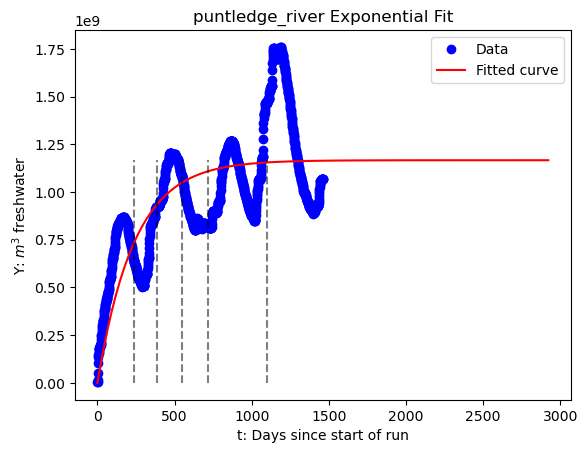

Optimized parameters:
A = 1217291651 m^3
T = 300 days, 0.82 years
T_80pct = 1.32 years
T_90pct = 1.89 years
T_95pct = 2.46 years
T_99pct = 3.78 years


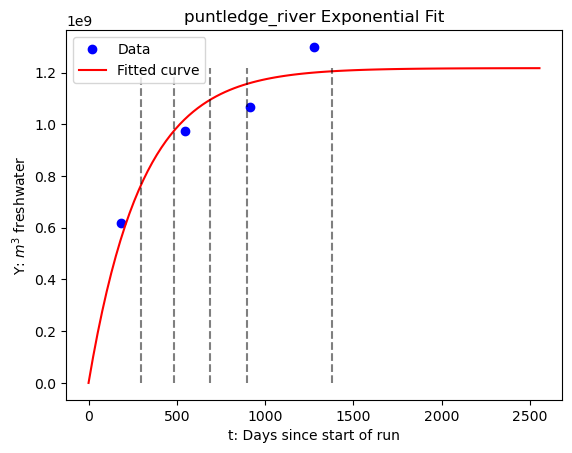

Optimized parameters:
A = 1300295519 m^3
T = 352 days, 0.97 years
T_80pct = 1.55 years
T_90pct = 2.22 years
T_95pct = 2.89 years
T_99pct = 4.45 years


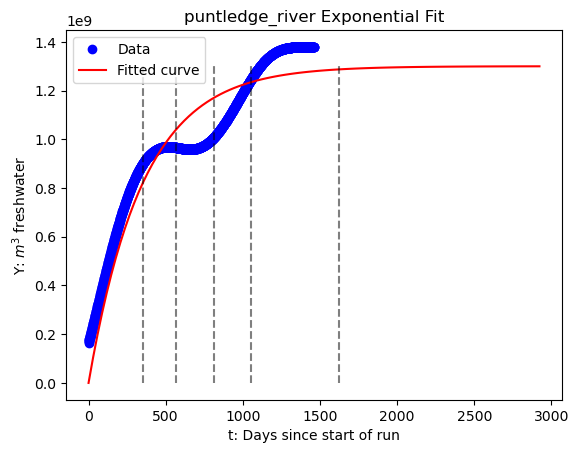

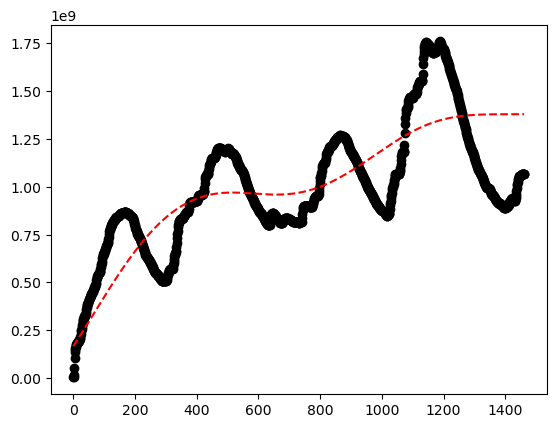

In [23]:
variable = 'puntledge_river'
days, vols = days_vols(idxs, fw_rivers_subset, puntledge_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_puntledge_data, T_opt_puntledge_data, T_95pct_puntledge_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(puntledge_arr)), Y_data=puntledge_arr, region=variable)

chunk_size = 365
data_arr = puntledge_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_puntledge_mean, T_opt_puntledge_mean, T_95pct_puntledge_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, puntledge_arr)
A_opt_puntledge, T_opt_puntledge, T_95pct_puntledge = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(puntledge_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(puntledge_arr)), puntledge_arr, 'ko')
plt.plot(np.arange(0, len(puntledge_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 649715237 m^3
T = 458 days, 1.26 years
T_80pct = 2.02 years
T_90pct = 2.89 years
T_95pct = 3.76 years
T_99pct = 5.78 years


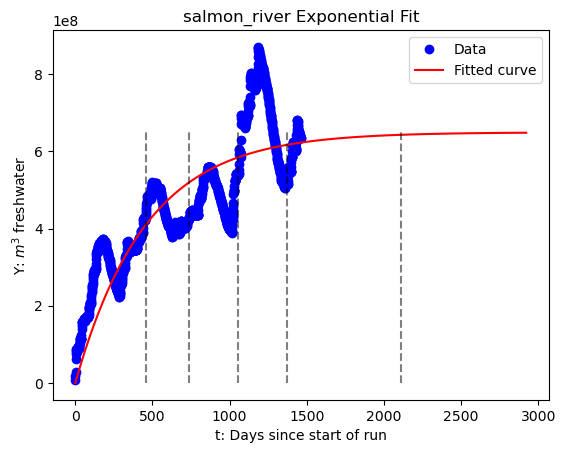

Optimized parameters:
A = 680504185 m^3
T = 523 days, 1.43 years
T_80pct = 2.30 years
T_90pct = 3.30 years
T_95pct = 4.29 years
T_99pct = 6.59 years


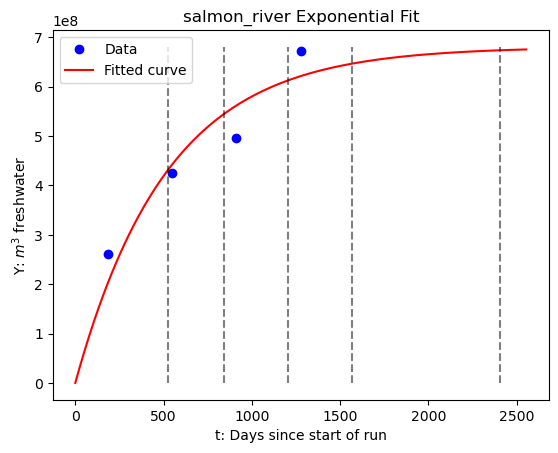

Optimized parameters:
A = 678085298 m^3
T = 515 days, 1.41 years
T_80pct = 2.27 years
T_90pct = 3.25 years
T_95pct = 4.23 years
T_99pct = 6.49 years


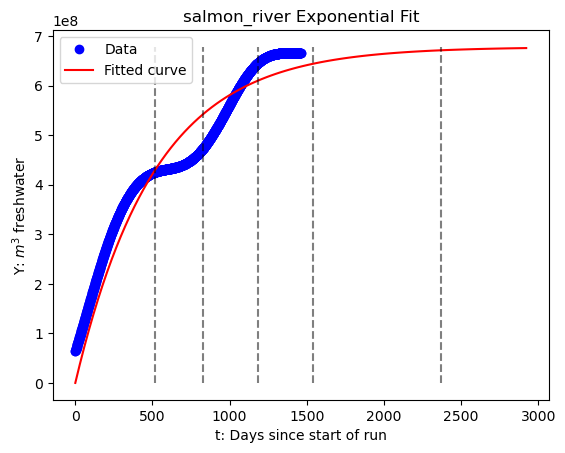

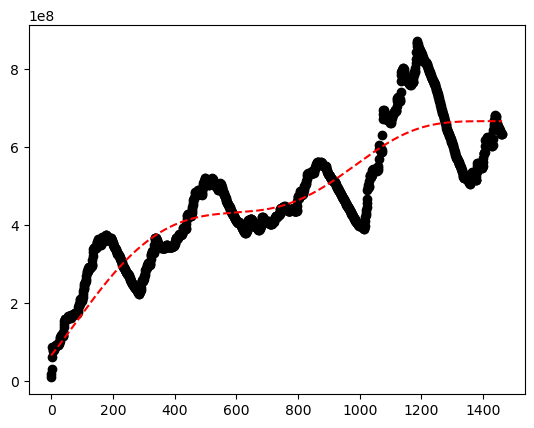

In [24]:
variable = 'salmon_river'
days, vols = days_vols(idxs, fw_rivers_subset, salmon_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_salmon_data, T_opt_salmon_data, T_95pct_salmon_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(salmon_arr)), Y_data=salmon_arr, region=variable)

chunk_size = 365
data_arr = salmon_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_salmon_mean, T_opt_salmon_mean, T_95pct_salmon_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, salmon_arr)
A_opt_salmon, T_opt_salmon, T_95pct_salmon = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(salmon_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(salmon_arr)), salmon_arr, 'ko')
plt.plot(np.arange(0, len(salmon_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 14719238725 m^3
T = 710 days, 1.95 years
T_80pct = 3.13 years
T_90pct = 4.48 years
T_95pct = 5.83 years
T_99pct = 8.96 years


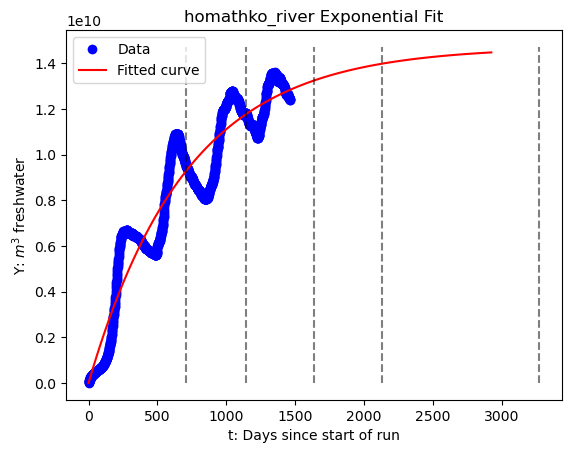

Optimized parameters:
A = 14329793992 m^3
T = 691 days, 1.89 years
T_80pct = 3.05 years
T_90pct = 4.36 years
T_95pct = 5.67 years
T_99pct = 8.72 years


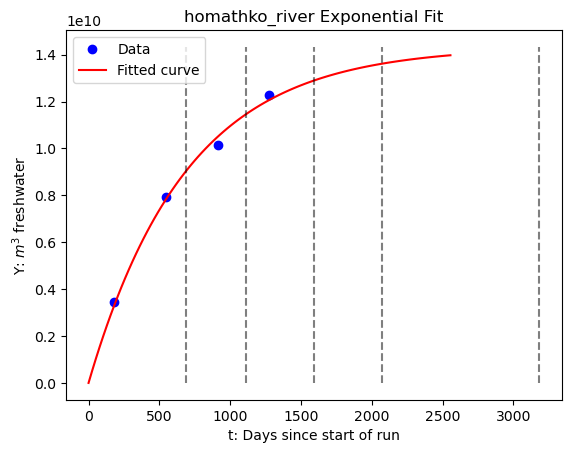

Optimized parameters:
A = 13632240281 m^3
T = 628 days, 1.72 years
T_80pct = 2.77 years
T_90pct = 3.96 years
T_95pct = 5.15 years
T_99pct = 7.92 years


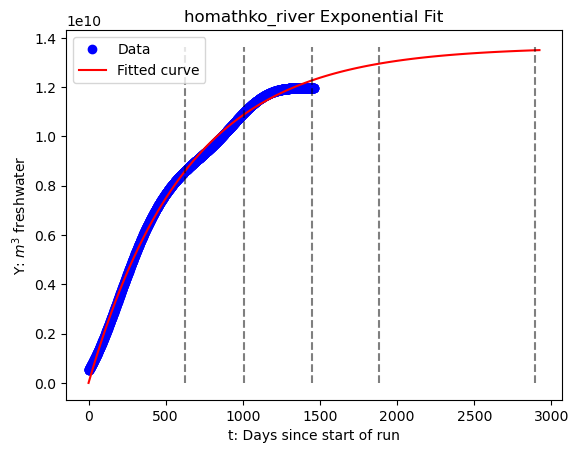

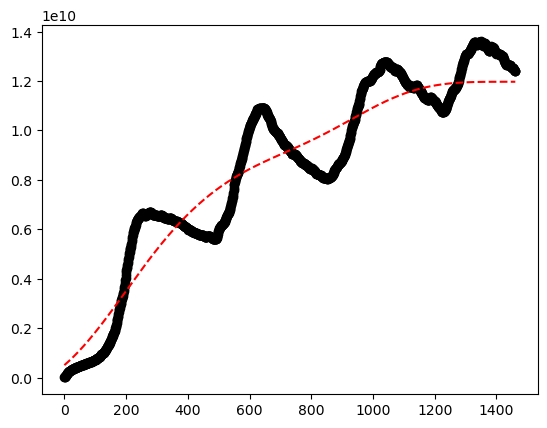

In [25]:
variable = 'homathko_river'
days, vols = days_vols(idxs, fw_rivers_subset, homathko_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_homathko_data, T_opt_homathko_data, T_95pct_homathko_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(homathko_arr)), Y_data=homathko_arr, region=variable)

chunk_size = 365
data_arr = homathko_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_homathko_mean, T_opt_homathko_mean, T_95pct_homathko_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, homathko_arr)
A_opt_homathko, T_opt_homathko, T_95pct_homathko = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(homathko_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(homathko_arr)), homathko_arr, 'ko')
plt.plot(np.arange(0, len(homathko_arr)), filtered_signal, 'r--')

Optimized parameters:
A = 11078543659 m^3
T = 565 days, 1.55 years
T_80pct = 2.49 years
T_90pct = 3.56 years
T_95pct = 4.64 years
T_99pct = 7.13 years


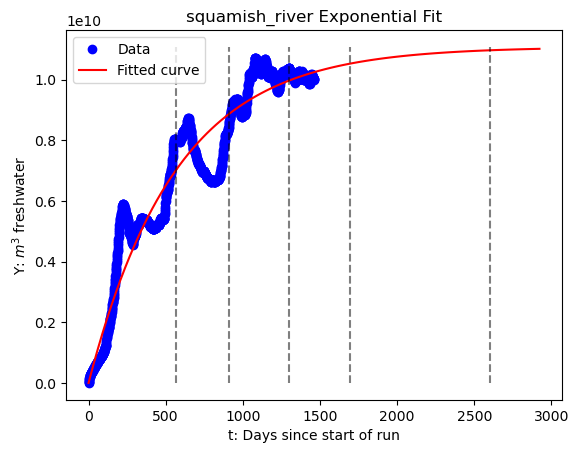

Optimized parameters:
A = 11059225817 m^3
T = 579 days, 1.59 years
T_80pct = 2.55 years
T_90pct = 3.65 years
T_95pct = 4.75 years
T_99pct = 7.30 years


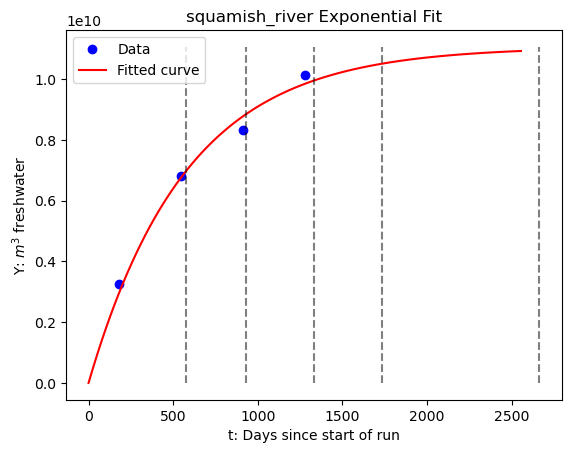

Optimized parameters:
A = 11009897067 m^3
T = 566 days, 1.55 years
T_80pct = 2.50 years
T_90pct = 3.57 years
T_95pct = 4.65 years
T_99pct = 7.15 years


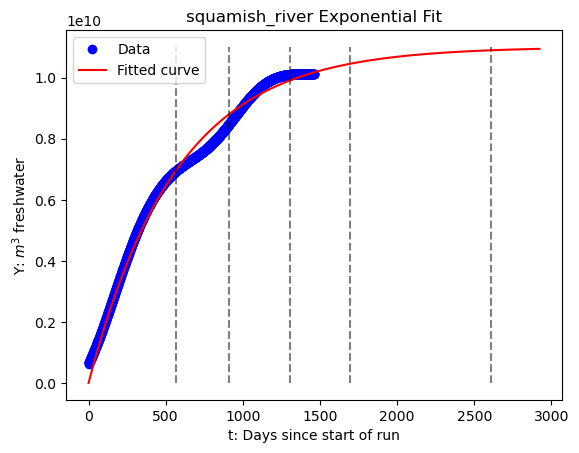

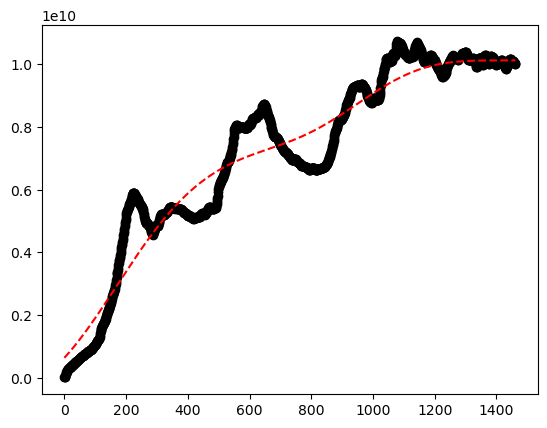

In [26]:
variable = 'squamish_river'
days, vols = days_vols(idxs, fw_rivers_subset, squamish_arr)
# A_opt, T_opt, T_95pct = fit_and_plot(initial_guess=(7e12, 300), t_data=idxs, Y_data=vols, region=variable)
A_opt_squamish_data, T_opt_squamish_data, T_95pct_squamish_data = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(squamish_arr)), Y_data=squamish_arr, region=variable)

chunk_size = 365
data_arr = squamish_arr[:-2]
resample_data = resample_mean(data_arr, chunk_size)
A_opt_squamish_mean, T_opt_squamish_mean, T_95pct_squamish_mean = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(data_arr), chunk_size)+(chunk_size/2), Y_data=resample_data, region=variable)

## low-pass filter
filtered_signal = signal.filtfilt(b, a, squamish_arr)
A_opt_squamish, T_opt_squamish, T_95pct_squamish = fit_and_plot(initial_guess=(7e8, 300), t_data=np.arange(0, len(squamish_arr)), Y_data=filtered_signal, region=variable)

plt.plot(np.arange(0, len(squamish_arr)), squamish_arr, 'ko')
plt.plot(np.arange(0, len(squamish_arr)), filtered_signal, 'r--')

In [27]:
river_names = ['fraser', 'nooksack', 'skagit', 'snohomish', 'nisqually', 'elwha', 'cowichan', 'nanaimo', 'puntledge', 'salmon', 'homathko', 'squamish']
T_opt_list = [T_opt_fraser, T_opt_nooksack, T_opt_skagit, T_opt_snohomish, T_opt_nisqually, T_opt_elwha, T_opt_cowichan, T_opt_nanaimo, T_opt_puntledge, T_opt_salmon, T_opt_homathko, T_opt_squamish]
A_opt_list = [A_opt_fraser, A_opt_nooksack, A_opt_skagit, A_opt_snohomish, A_opt_nisqually, A_opt_elwha, A_opt_cowichan, A_opt_nanaimo, A_opt_puntledge, A_opt_salmon, A_opt_homathko, A_opt_squamish]
T_95pct_list = [T_95pct_fraser, T_95pct_nooksack, T_95pct_skagit, T_95pct_snohomish, T_95pct_nisqually, T_95pct_elwha, T_95pct_cowichan, T_95pct_nanaimo, T_95pct_puntledge, T_95pct_salmon, T_95pct_homathko, T_95pct_squamish]
T_opt_data_list = [T_opt_fraser_data, T_opt_nooksack_data, T_opt_skagit_data, T_opt_snohomish_data, T_opt_nisqually_data, T_opt_elwha_data, T_opt_cowichan_data, T_opt_nanaimo_data, T_opt_puntledge_data, T_opt_salmon_data, T_opt_homathko_data, T_opt_squamish_data]
T_opt_mean_list = [T_opt_fraser_mean, T_opt_nooksack_mean, T_opt_skagit_mean, T_opt_snohomish_mean, T_opt_nisqually_mean, T_opt_elwha_mean, T_opt_cowichan_mean, T_opt_nanaimo_mean, T_opt_puntledge_mean, T_opt_salmon_mean, T_opt_homathko_mean, T_opt_squamish_mean]

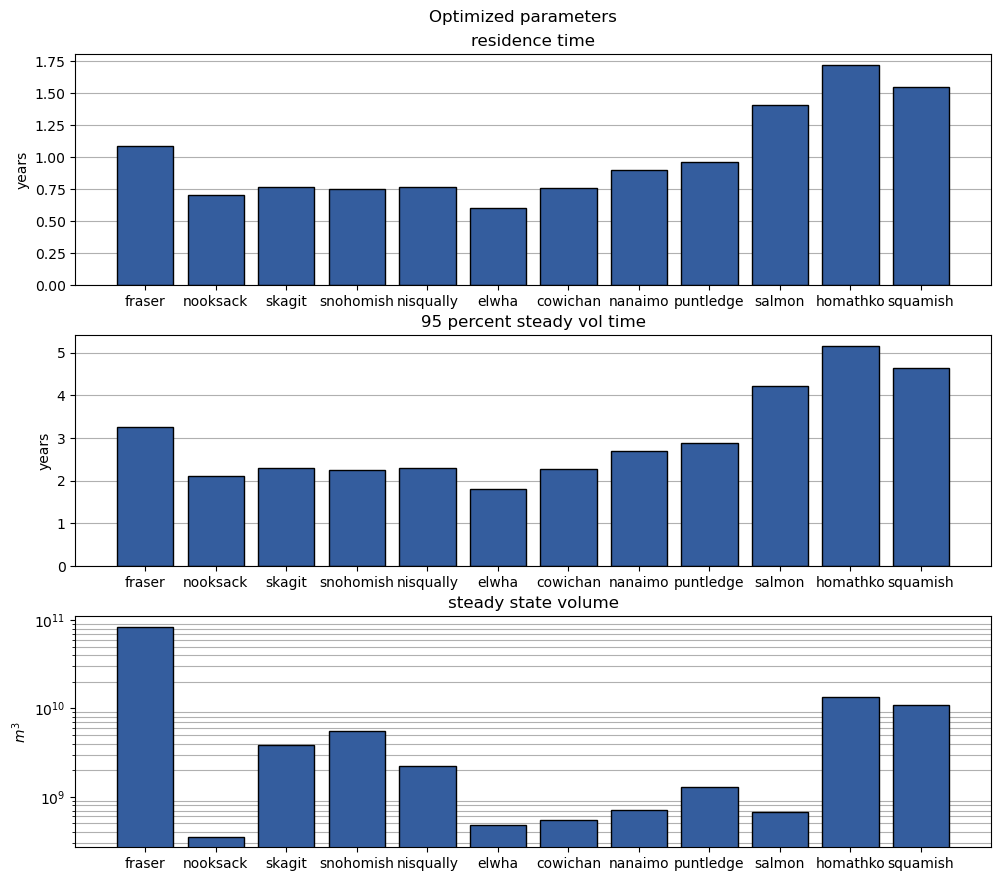

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(10, 9))
fig.suptitle('Optimized parameters')
fig.tight_layout(pad=1.5)

# ax[0].scatter(river_names, np.array(T_opt_list)/365)
ax[0].bar(river_names, np.array(T_opt_list)/365, facecolor=color3, edgecolor='k', zorder=2)
ax[0].set_ylabel('years')
ax[0].set_title('residence time')
ax[0].grid(axis='y', zorder=0)

ax[1].bar(river_names, np.array(T_95pct_list)/365, facecolor=color3, edgecolor='k', zorder=2)
ax[1].set_ylabel(r'years')
ax[1].set_title('95 percent steady vol time')
ax[1].grid(axis='y', zorder=0)

# ax[1].scatter(river_names, A_opt_list)
ax[2].bar(river_names, A_opt_list, facecolor=color3, edgecolor='k', zorder=2)
ax[2].set_ylabel(r'$m^3$')
ax[2].set_title('steady state volume')
ax[2].grid(axis='y', which='minor', zorder=0)
ax[2].set_yscale('log')

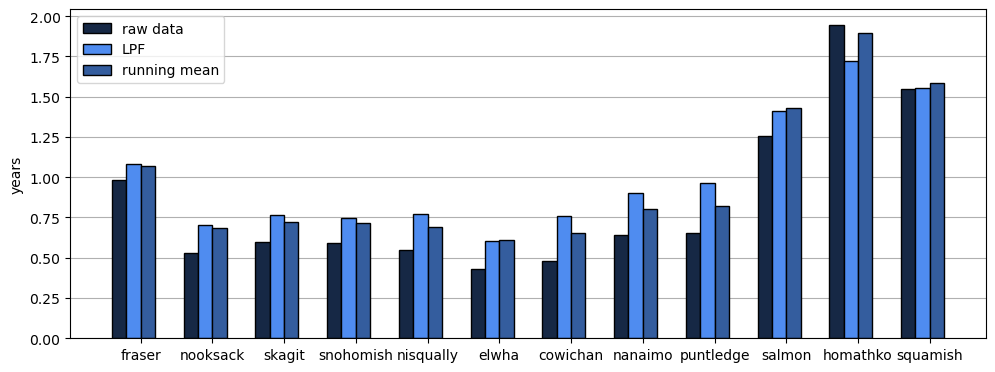

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
fig.tight_layout(pad=1.5)

bar_width = 0.2
x = np.arange(len(river_names))

## rmse, crmse, systematic, nonsystematic
ax.grid(axis='y', zorder=0)
ax.bar(x - 1.5 * bar_width, np.array(T_opt_data_list)/365, label='raw data', width=bar_width, edgecolor='k', color=color2, zorder=2)
ax.bar(x - 0.5 * bar_width, np.array(T_opt_list)/365, label='LPF', width=bar_width, edgecolor='k', color=color1, zorder=2)
ax.bar(x + 0.5 * bar_width, np.array(T_opt_mean_list)/365, label='running mean', width=bar_width, edgecolor='k', color=color3, zorder=2)
ax.set_xticks(x, river_names)
ax.set_ylabel(r'years')
ax.legend()

/tmp/ipykernel_4179074/3403796783.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(river_names, rotation=45)


[Text(0, 0, 'fraser'),
 Text(1, 0, 'nooksack'),
 Text(2, 0, 'skagit'),
 Text(3, 0, 'snohomish'),
 Text(4, 0, 'nisqually'),
 Text(5, 0, 'elwha'),
 Text(6, 0, 'cowichan'),
 Text(7, 0, 'nanaimo'),
 Text(8, 0, 'puntledge'),
 Text(9, 0, 'salmon'),
 Text(10, 0, 'homathko'),
 Text(11, 0, 'squamish')]

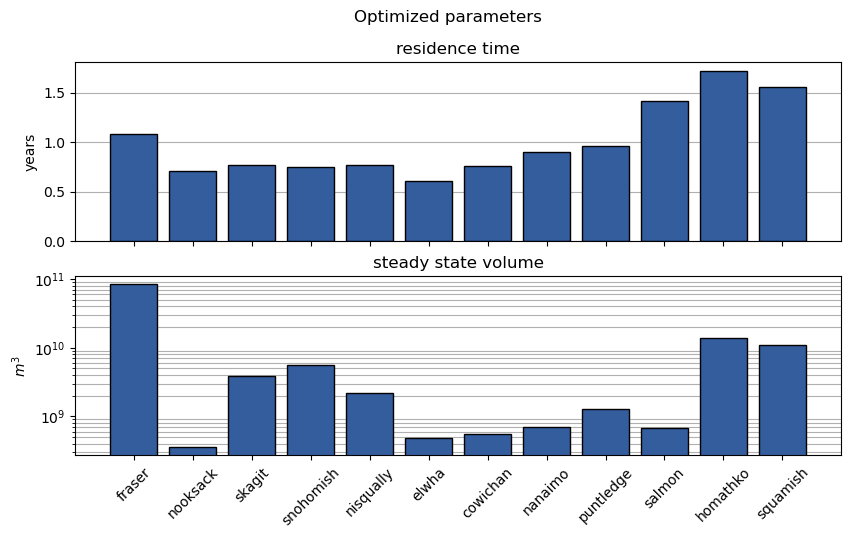

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(8.5, 5), sharex=True)
fig.suptitle('Optimized parameters')
fig.tight_layout(pad=1.5)

# ax[0].scatter(river_names, np.array(T_opt_list)/365)
ax[0].bar(river_names, np.array(T_opt_list)/365, facecolor=color3, edgecolor='k', zorder=2)
ax[0].set_ylabel('years')
ax[0].set_title('residence time')
ax[0].grid(axis='y', zorder=0)
# ax[0].set_xticklabels(river_names, rotation=45)

ax[1].bar(river_names, A_opt_list, facecolor=color3, edgecolor='k', zorder=2)
ax[1].set_ylabel(r'$m^3$')
ax[1].set_title('steady state volume')
ax[1].grid(axis='y', which='minor', zorder=0)
ax[1].set_yscale('log')
ax[1].set_xticklabels(river_names, rotation=45)

<BarContainer object of 11 artists>

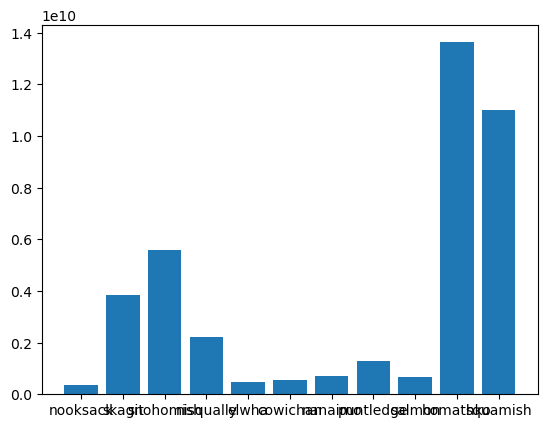

In [37]:
plt.bar(river_names[1:], A_opt_list[1:])

In [43]:
T_opt_list

[395.827982443063,
 257.4724658012153,
 279.85803484510785,
 273.2166897969224,
 280.52425575012904,
 220.60692747277074,
 276.1250185310502,
 328.7870859441393,
 352.3108600371771,
 514.7815294261669,
 627.8095184034335,
 566.3624489594253]

In [45]:
river_names

for idx in np.arange(len(river_names)):
    print('{}, {}days, {} years, {} m^3'.format(river_names[idx], T_opt_list[idx], np.array(T_opt_list[idx])/365, A_opt_list[idx]))

fraser, 395.827982443063days, 1.0844602258714053 years, 83879627822.059 m^3
nooksack, 257.4724658012153days, 0.7054040158937406 years, 353747709.0866116 m^3
skagit, 279.85803484510785days, 0.7667343420413913 years, 3832231543.2167583 m^3
snohomish, 273.2166897969224days, 0.7485388761559518 years, 5599838576.427526 m^3
nisqually, 280.52425575012904days, 0.7685596047948741 years, 2208729150.195103 m^3
elwha, 220.60692747277074days, 0.6044025410212897 years, 475744091.993365 m^3
cowichan, 276.1250185310502days, 0.756506900085069 years, 543507438.7891978 m^3
nanaimo, 328.7870859441393days, 0.9007865368332583 years, 707617541.0745583 m^3
puntledge, 352.3108600371771days, 0.9652352329785675 years, 1300295519.4448738 m^3
salmon, 514.7815294261669days, 1.410360354592238 years, 678085297.799978 m^3
homathko, 627.8095184034335days, 1.720026077817626 years, 13632240281.407467 m^3
squamish, 566.3624489594253days, 1.5516779423545897 years, 11009897067.291826 m^3


In [52]:
SSea_vol = 2342.94e9 

In [56]:
83879627822.05/SSea_vol * 100

3.5801014034525

In [57]:
353747709.0866116/SSea_vol * 100

0.015098453613264173

In [54]:
83879627822.059e-9

83.879627822059

In [47]:
13632240281.407467e-9

13.632240281407467

In [48]:
11009897067.291826e-9

11.009897067291826

In [49]:
678085297.799978e-9

0.678085297799978